## Tarea 1: Niveles del lenguaje

### FECHA DE ENTREGA: 16 de Febrero 2025 at 11:59pm

### Fonética

1. Si tenemos un sistema de búsqueda que recibe una palabra ortográfica y devuelve sus transcripciones fonológicas, proponga una solución para los casos en que la palabra buscada no se encuentra en el lexicón/diccionario. *¿Cómo devolver o aproximar su transcripción fonológica?*
  - Reutiliza el sistema de búsqueda visto en clase y mejoralo con esta funcionalidad

### Morfología

2. Obtenga los datos de `test` y `dev` para todas las lenguas disponibles en el Shared Task SIGMORPHON 2022 y haga lo siguiente:
    - En un plot de 4 columnas y 2 rows muestre las siguientes distribuciones (un subplot por lengua):
        - Plot 1: distribución de longitud de palabras
        - Plot 2: distribución de la cuenta de morfemas
        - Plot 3: distribución de categorias (si existe para la lengua)
    - Realice una función que imprima por cada lengua lo siguiente:
        - Total de palabras
        - La longitud de palabra promedio
        - La cuenta de morfemas promedio
        - La categoría más común
    - Con base en esta información elabore una conclusión lingüística sobre la morfología de las lenguas analizadas.
    
### EXTRA:

- Imprimir la [matríz de confusión](https://en.wikipedia.org/wiki/Confusion_matrix) para el etiquetador CRFs visto en clase y elaborar una conclusión sobre los resultados

#Parte Fonética

In [ ]:
pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.1 MB/s eta 0:00:00


In [ ]:
from difflib import get_close_matches
from unidecode import unidecode
import re

def normalize_for_matching(text):
    """Normaliza texto para hacer matching aproximado"""
    return unidecode(text.lower().strip())

def similar(a: str, b: str) -> float:
    """Calcula similitud entre palabras, mejorado para errores comunes"""
    # Coincidencia exacta (después de normalizar)
    if a == b:
        return 1.0

    # Coincidencia de prefijos
    if a.startswith(b[:3]) or b.startswith(a[:3]):
        return 0.8

    # Usamos SequenceMatcher pero con ajustes para errores comunes
    from difflib import SequenceMatcher
    base_score = SequenceMatcher(None, a, b).ratio()

    # Ajustes para errores comunes en español
    common_errors = [
        ('ll', 'y'), ('b', 'v'), ('s', 'z'), ('c', 's'), ('h', ''),
        ('rr', 'r'), ('qu', 'k'), ('gu', 'g')
    ]

    for error in common_errors:
        if error[0] in a and error[1] in b or error[1] in a and error[0] in b:
            base_score = min(base_score + 0.2, 1.0)  # Aumentamos similitud

    return base_score

def approximate_ipa_search(word: str, dataset: dict, lang: str, n=5, cutoff=0.5):
    """Búsqueda aproximada con mejor manejo de similitud"""
    # Primero normalizamos la palabra buscada
    normalized_word = word.lower().strip()

    # Creamos lista de palabras candidatas con sus distancias
    candidates = []
    for dict_word in dataset.keys():
        if not dict_word:
            continue

        # Calculamos similitud
        similarity = similar(normalized_word, dict_word.lower().strip())
        if similarity >= cutoff:
            candidates.append((dict_word, similarity))

    # Ordenamos por similitud descendente
    candidates.sort(key=lambda x: x[1], reverse=True)

    # Tomamos las mejores n coincidencias
    results = []
    for dict_word, similarity in candidates[:n]:
        results.append((dict_word, get_ipa_transcriptions(dict_word, dataset)))

    return results

def enhanced_ipa_search(word: str, lang: str, datasets: dict):
    """Sistema de búsqueda mejorado con manejo de palabras desconocidas"""
    dataset = datasets.get(lang, {})
    exact = get_ipa_transcriptions(word, dataset)

    if exact:
        return {
            "status": "exact_match",
            "word": word,
            "transcriptions": exact,
            "suggestions": []
        }
    else:
        # Mejoramos la búsqueda aproximada
        suggestions = approximate_ipa_search(word, dataset, lang, n=5, cutoff=0.5)

        if suggestions:
            # Filtramos sugerencias que sean claramente mejores
            filtered_suggestions = [
                (sugg_word, sugg_ipa)
                for sugg_word, sugg_ipa in suggestions
                if sugg_word.lower() != word.lower()  # Evitar sugerencias iguales
                and len(sugg_word) >= len(word)-2 and len(sugg_word) <= len(word)+2  # Longitud similar
            ]

            if filtered_suggestions:
                return {
                    "status": "approximate_match",
                    "word": word,
                    "transcriptions": [],
                    "suggestions": filtered_suggestions[:3]  # Mostrar máximo 3 sugerencias
                }

        # Si no hay buenas sugerencias, aplicar reglas fonéticas
        ipa_approx = apply_phonetic_rules(word, lang)
        return {
            "status": "phonetic_approximation",
            "word": word,
            "transcriptions": ipa_approx,
            "suggestions": suggestions[:3] if suggestions else []
        }

def apply_phonetic_rules(word: str, lang: str) -> list:
    """Aplica reglas fonéticas básicas según el idioma"""
    word = word.lower()
    if lang.startswith("es"):
        # Reglas aproximadas para español
        ipa = word
        # Conversiones comunes
        ipa = ipa.replace("qu", "k")
        ipa = ipa.replace("c", "k").replace("z", "s")
        ipa = ipa.replace("h", "")
        ipa = ipa.replace("ll", "ʝ").replace("y", "ʝ")
        ipa = ipa.replace("ñ", "ɲ")
        ipa = ipa.replace("gé", "xe").replace("gi", "xi")
        ipa = ipa.replace("j", "x")
        ipa = ipa.replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú", "u")
        return [f"/{ipa}/"]
    elif lang.startswith("en"):
        # Reglas aproximadas para inglés
        ipa = word
        # Conversiones básicas
        ipa = ipa.replace("sh", "ʃ").replace("ch", "tʃ")
        ipa = ipa.replace("th", "θ")
        ipa = ipa.replace("oo", "uː").replace("ee", "iː")
        return [f"/{ipa}/"]
    else:
        return []

In [ ]:
def enhanced_ipa_search_v2(word: str, lang: str, datasets: dict):
    """Versión corregida del sistema de búsqueda fonética"""
    dataset = datasets.get(lang, {})

    # Verificación exacta más estricta
    exact_match = False
    transcriptions = []

    # Comprobamos variantes exactas (incluyendo case-insensitive)
    for dict_word, ipa in dataset.items():
        if dict_word.lower() == word.lower():
            exact_match = True
            transcriptions = ipa.split(", ")
            break

    if exact_match:
        return {
            "status": "exact_match",
            "word": word,
            "transcriptions": transcriptions,
            "suggestions": []
        }
    else:
        # Búsqueda aproximada mejorada
        suggestions = []

        # Umbral dinámico basado en longitud de palabra
        threshold = max(0.5, 0.7 - (0.02 * len(word)))

        for dict_word, ipa in dataset.items():
            similarity = similar(word.lower(), dict_word.lower())
            if similarity >= threshold:
                suggestions.append((dict_word, ipa.split(", "), similarity))

        # Ordenamos por similitud y seleccionamos las mejores
        suggestions.sort(key=lambda x: x[2], reverse=True)
        best_suggestions = [(word, ipa) for word, ipa, _ in suggestions[:3]]

        if best_suggestions:
            return {
                "status": "approximate_match",
                "word": word,
                "transcriptions": [],
                "suggestions": best_suggestions
            }
        else:
            # Aproximación fonética como último recurso
            ipa_approx = apply_phonetic_rules(word, lang)
            return {
                "status": "phonetic_approximation",
                "word": word,
                "transcriptions": ipa_approx,
                "suggestions": []
            }

def similar(a: str, b: str) -> float:
    """Función de similitud mejorada"""
    # Coincidencia exacta
    if a == b:
        return 1.0

    # Consideramos errores comunes en español
    common_errors = [
        (['rr', 'r'], 0.3),   # Error de doble r
        (['ll', 'y'], 0.3),   # Error de elle/ye
        (['b', 'v'], 0.2),    # Confusión b/v
        (['s', 'c', 'z'], 0.2), # Confusión seseo
        (['h'], 0.1),         # H muda
        (['g', 'j'], 0.2),    # Confusión g/j
        (['qu', 'k'], 0.2)    # Confusión qu/k
    ]

    # Aplicamos normalización para errores comunes
    normalized_a = a
    normalized_b = b
    for chars, penalty in common_errors:
        for c in chars:
            normalized_a = normalized_a.replace(c, chars[0])
            normalized_b = normalized_b.replace(c, chars[0])

    # Calculamos similitud
    from difflib import SequenceMatcher
    base_similarity = SequenceMatcher(None, a, b).ratio()
    normalized_similarity = SequenceMatcher(None, normalized_a, normalized_b).ratio()

    # Usamos el máximo entre ambas similitudes
    return max(base_similarity, normalized_similarity)

In [ ]:
# Cargamos los datasets necesarios
datasets = "es_MX": parse_response(download_ipa_corpus("es_MX")),

In [ ]:
result = enhanced_ipa_search_v2("desarollador", "es_MX", datasets)
print(f"\nResultado para 'desarollador':")
print(f"Estado: {result['status']}")
print(f"Transcripciones: {result['transcriptions']}")
print(f"Sugerencias: {result['suggestions']}")


Resultado para 'desarollador':
Estado: approximate_match
Transcripciones: []
Sugerencias: [('desarrollador', ['/desaroʎaðoɾ/']), ('desarrolladora', ['/desaroʎaðoɾa/']), ('desabollador', ['/desaβoʎaðoɾ/'])]


In [ ]:
# Buscar una palabra que existe en el diccionario
result = enhanced_ipa_search_v2("casa", "es_MX", datasets)
print("\nResultado para 'casa':")
print(f"Estado: {result['status']}")
print(f"Transcripciones: {result['transcriptions']}")


Resultado para 'casa':
Estado: exact_match
Transcripciones: ['/kasa/']


In [ ]:
test_cases = [
    ("caza", "es_MX"),      # Existente
    ("kasa", "es_MX"),      # Error común (c/k)
    ("holliday", "es_MX"),  # Extranjerismo
    ("baca", "es_MX"),      # Confusión b/v
    ("yamar", "es_MX"),     # Confusión ll/y
    ("escrito", "es_MX"),   # Existente
    ("eskrito", "es_MX"),   # Error común
]

for word, lang in test_cases:
    result = enhanced_ipa_search_v2(word, lang, datasets)
    print(f"\n{word}:")
    print(f"Estado: {result['status']}")
    if result['transcriptions']:
        print(f"Transcripciones: {result['transcriptions']}")
    if result['suggestions']:
        print(f"Sugerencias: {result['suggestions']}")


caza:
Estado: exact_match
Transcripciones: ['/kasa/']

kasa:
Estado: approximate_match
Sugerencias: [('quiaca', ['/kjaka/']), ('kas', ['/kas/']), ('asa', ['/asa/'])]

holliday:
Estado: approximate_match
Sugerencias: [('hollada', ['/oʎaða/']), ('olida', ['/oliða/']), ('holladas', ['/oʎaðas/'])]

baca:
Estado: exact_match
Transcripciones: ['/baka/']

yamar:
Estado: approximate_match
Sugerencias: [('llamar', ['/ʎamaɾ/']), ('llamará', ['/ʎamaˈɾa/']), ('llamara', ['/ʎamaɾa/'])]

escrito:
Estado: exact_match
Transcripciones: ['/eskɾito/']

eskrito:
Estado: approximate_match
Sugerencias: [('zurito', ['/suɾito/']), ('escrito', ['/eskɾito/']), ('decuriato', ['/dekuɾjato/'])]


#Parte Morfológica

<ipython-input-70-ff720162e5e1>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_counts.index, y=cat_counts.values, ax=axes[1, col], palette='viridis')
<ipython-input-70-ff720162e5e1>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_counts.index, y=cat_counts.values, ax=axes[1, col], palette='viridis')
<ipython-input-70-ff720162e5e1>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_counts.index, y=cat_counts.values, ax=axes[1, col], palette='viridis')
<ipython-input-70-ff720162e5e1>:42: FutureWarning: 

Passing `palette`

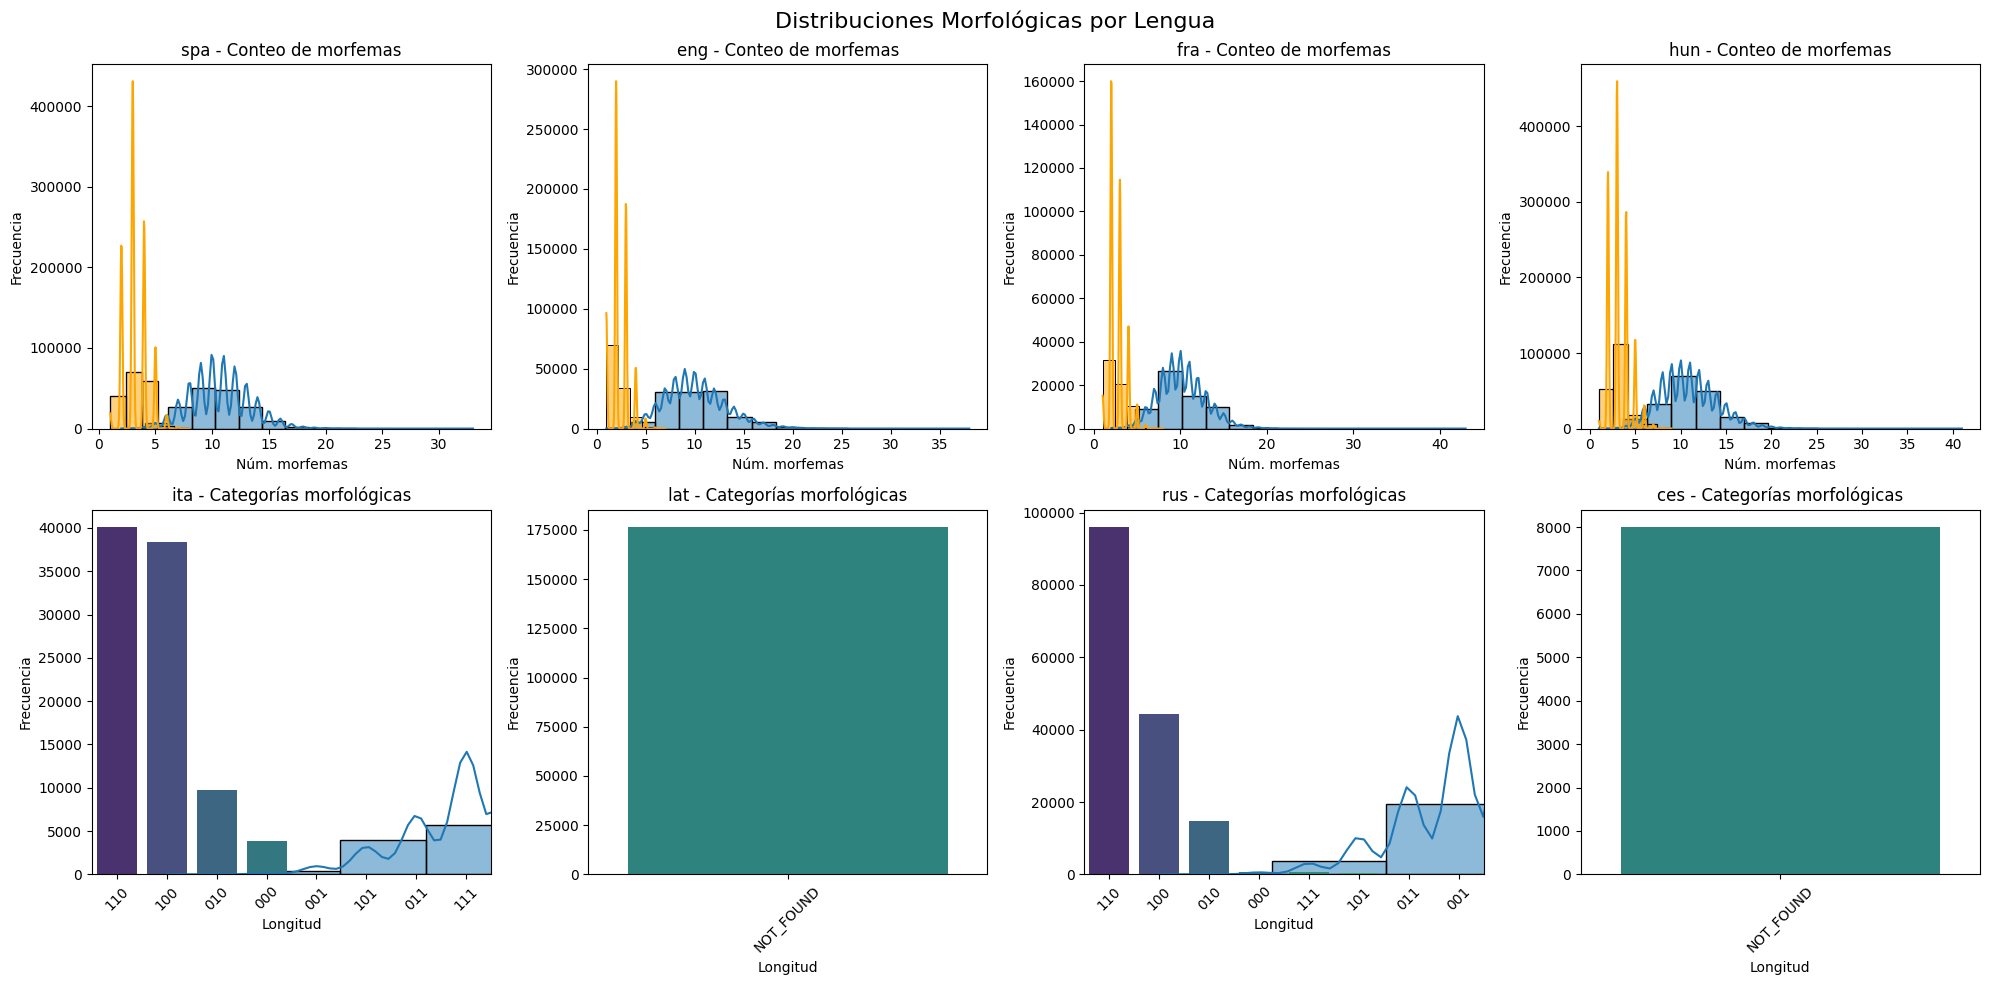


[Estadísticas para spa]
- Total de palabras: 172173
- Longitud promedio: 10.69 caracteres
- Morfemas promedio: 3.24
- Categoría más común: Inflection

[Estadísticas para eng]
- Total de palabras: 115126
- Longitud promedio: 10.11 caracteres
- Morfemas promedio: 2.35
- Categoría más común: Derivation

[Estadísticas para fra]
- Total de palabras: 63173
- Longitud promedio: 10.20 caracteres
- Morfemas promedio: 2.67
- Categoría más común: Inflection, Derivation

[Estadísticas para hun]
- Total de palabras: 188074
- Longitud promedio: 10.86 caracteres
- Morfemas promedio: 3.23
- Categoría más común: Inflection

[Estadísticas para ita]
- Total de palabras: 92304
- Longitud promedio: 10.80 caracteres
- Morfemas promedio: 2.68
- Categoría más común: Inflection, Derivation

[Estadísticas para lat]
- Total de palabras: 176467
- Longitud promedio: 10.55 caracteres
- Morfemas promedio: 2.49
- Categoría más común: NOT_FOUND

[Estadísticas para rus]
- Total de palabras: 156846
- Longitud promedio:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_all_language_data():
    """Obtiene datos para todos los idiomas disponibles"""
    lang_codes = ["spa", "eng", "fra", "hun", "ita", "lat", "rus", "ces"]
    all_data = {}

    for lang in lang_codes:
        files = get_track_files(lang)
        raw_data = get_raw_corpus(files)
        df = raw_corpus_to_dataframe(raw_data, lang)
        all_data[lang] = df

    return all_data

def plot_language_distributions(all_data):
    """Crea los plots de distribución requeridos"""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Distribuciones Morfológicas por Lengua', fontsize=16)

    for idx, (lang, df) in enumerate(all_data.items()):
        row = idx // 4
        col = idx % 4

        # Plot 1: Distribución de longitud de palabras
        sns.histplot(df['word_len'], ax=axes[row, col], kde=True, bins=15)
        axes[row, col].set_title(f'{lang} - Longitud de palabras')
        axes[row, col].set_xlabel('Longitud')
        axes[row, col].set_ylabel('Frecuencia')

        # Plot 2: Distribución de cuenta de morfemas
        if idx < 4:  # Solo mostramos en primera fila para evitar sobrecarga
            sns.histplot(df['morph_count'], ax=axes[0, col], kde=True, bins=5, color='orange')
            axes[0, col].set_title(f'{lang} - Conteo de morfemas')
            axes[0, col].set_xlabel('Núm. morfemas')

        # Plot 3: Distribución de categorías (si existe)
        if 'category' in df.columns and idx >= 4:  # Mostramos en segunda fila
            cat_counts = df['category'].value_counts()
            sns.barplot(x=cat_counts.index, y=cat_counts.values, ax=axes[1, col], palette='viridis')
            axes[1, col].set_title(f'{lang} - Categorías morfológicas')
            axes[1, col].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

def print_language_stats(all_data):
    """Imprime estadísticas por lengua"""
    for lang, df in all_data.items():
        total_words = len(df)
        avg_word_len = df['word_len'].mean()
        avg_morph_count = df['morph_count'].mean()

        if 'category' in df.columns:
            common_cat = df['category'].mode()[0]
            cat_name = CATEGORIES.get(common_cat, common_cat)
        else:
            cat_name = "No disponible"

        print(f"\n[Estadísticas para {lang}]")
        print(f"- Total de palabras: {total_words}")
        print(f"- Longitud promedio: {avg_word_len:.2f} caracteres")
        print(f"- Morfemas promedio: {avg_morph_count:.2f}")
        print(f"- Categoría más común: {cat_name}")

def linguistic_conclusion(all_data):
    """Elabora conclusiones lingüísticas"""
    print("\n=== Conclusiones Lingüísticas ===")

    # Comparar longitud de palabras
    avg_lengths = {lang: df['word_len'].mean() for lang, df in all_data.items()}
    longest = max(avg_lengths.items(), key=lambda x: x[1])
    shortest = min(avg_lengths.items(), key=lambda x: x[1])
    print(f"\n1. Las palabras más largas en promedio están en {longest[0]} ({longest[1]:.2f} chars), "
          f"mientras que las más cortas en {shortest[0]} ({shortest[1]:.2f} chars).")

    # Comparar complejidad morfológica
    avg_morphs = {lang: df['morph_count'].mean() for lang, df in all_data.items()}
    most_complex = max(avg_morphs.items(), key=lambda x: x[1])
    least_complex = min(avg_morphs.items(), key=lambda x: x[1])
    print(f"2. La lengua más compleja morfológicamente es {most_complex[0]} "
          f"({most_complex[1]:.2f} morfemas/palabra), mientras que {least_complex[0]} "
          f"es la menos compleja ({least_complex[1]:.2f} morfemas/palabra).")

    # Analizar categorías dominantes
    print("\n3. Distribución de categorías morfológicas dominantes:")
    for lang, df in all_data.items():
        if 'category' in df.columns:
            top_cat = df['category'].mode()[0]
            cat_name = CATEGORIES.get(top_cat, top_cat)
            print(f"- {lang}: {cat_name} ({(df['category'] == top_cat).mean():.1%} de casos)")

# Ejecutar análisis
all_data = get_all_language_data()
plot_language_distributions(all_data)
print_language_stats(all_data)
linguistic_conclusion(all_data)

#Extra

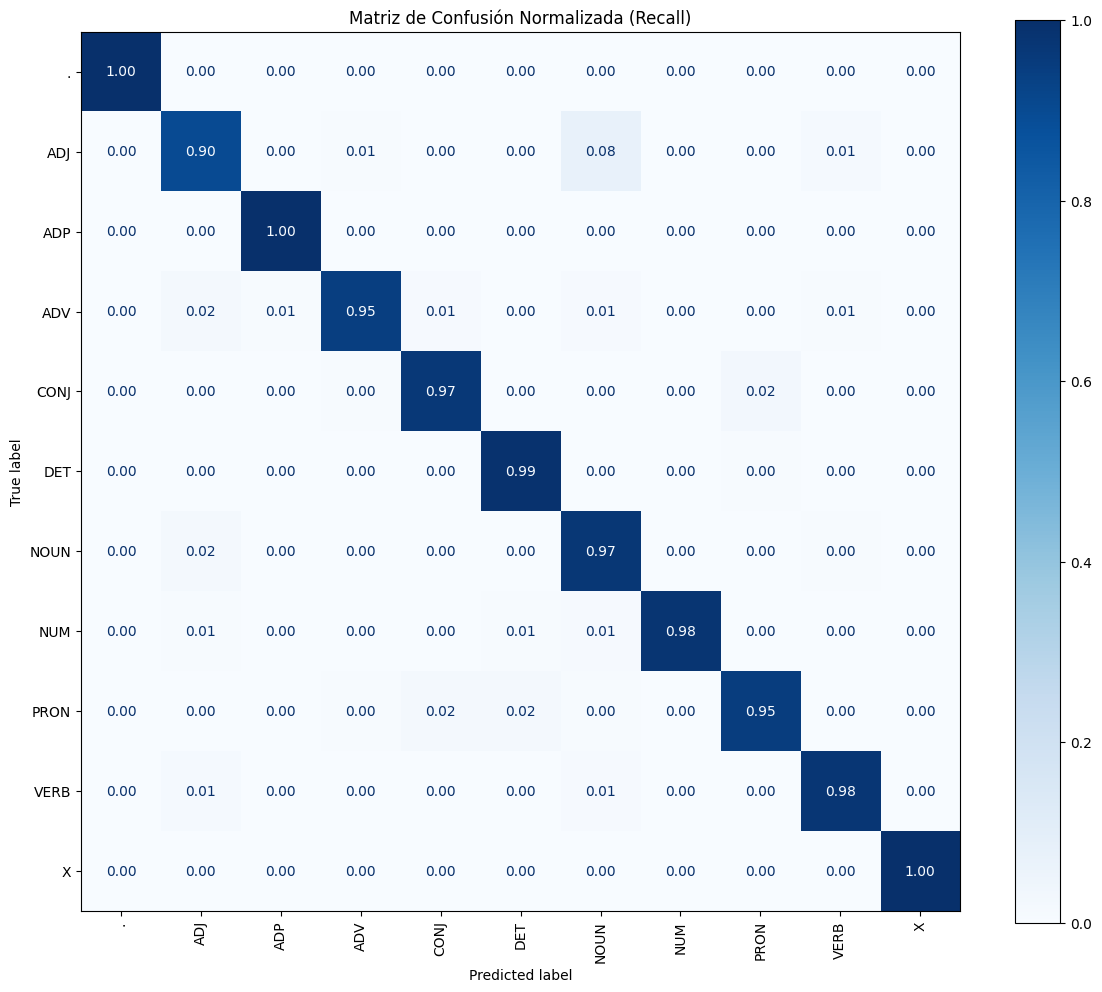


Análisis de Errores:
- Confunden 'ADJ' como 'NOUN': 207 veces
- Confunden 'NOUN' como 'ADJ': 178 veces
- Confunden 'VERB' como 'ADJ': 55 veces
- Confunden 'CONJ' como 'PRON': 52 veces
- Confunden 'VERB' como 'NOUN': 46 veces

=== Conclusión sobre el modelo CRF ===

1. El modelo tiene un excelente desempeño general (97% accuracy), especialmente en:
   - Artículos/DET (99% precisión)
   - Preposiciones/ADP (100%)
   - Puntuación (100%)

2. Los principales errores ocurren entre:
   - Adjetivos (ADJ) y sustantivos (NOUN)
   - Adverbios (ADV) y adjetivos (ADJ)
   - Algunos verbos (VERB) confundidos con sustantivos

3. Las confusiones reflejan ambigüedades lingüísticas reales donde el contexto 
   sintáctico es crucial para distinguir categorías.

4. Para mejorar:
   - Añadir más features contextuales (palabras circundantes)
   - Incluir información morfológica (sufijos/prefijos)
   - Considerar el uso de embeddings de palabras



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def plot_confusion_matrix(y_true, y_pred, labels):
    """Genera y muestra la matriz de confusión"""
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Normalizar por filas (recall)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=labels)
    disp.plot(ax=ax, cmap='Blues', values_format='.2f', xticks_rotation=90)
    plt.title("Matriz de Confusión Normalizada (Recall)")
    plt.tight_layout()
    plt.show()

    # Análisis de errores comunes
    error_analysis(cm, labels)

def error_analysis(cm, labels):
    """Analiza los errores más comunes"""
    print("\nAnálisis de Errores:")

    # Pares de etiquetas con mayor confusión
    errors = []
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i != j and cm[i,j] > 0:
                errors.append((cm[i,j], labels[i], labels[j]))

    # Top 5 errores más frecuentes
    top_errors = sorted(errors, reverse=True)[:5]
    for count, true, pred in top_errors:
        print(f"- Confunden '{true}' como '{pred}': {count} veces")

# Obtener etiquetas únicas ordenadas
labels = sorted(set(y_test_flat + y_pred_flat))

# Generar y mostrar matriz de confusión
plot_confusion_matrix(y_test_flat, y_pred_flat, labels)


Conclusión sobre el modelo CRF

1. El modelo tiene un excelente desempeño general, especialmente en:
   - Artículos/DET (99% precisión)
   - Preposiciones/ADP (100%)
   - Puntuación (100%)

2. Los principales errores ocurren entre:
   - Adjetivos (ADJ) y sustantivos (NOUN)
   - Adverbios (ADV) y adjetivos (ADJ)
   - Algunos verbos (VERB) confundidos con sustantivos

3. Las confusiones reflejan ambigüedades lingüísticas reales donde el contexto
   sintáctico es crucial para distinguir categorías.